In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Fri Aug 20 03:57:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
%cd '/content/drive/MyDrive/DataScience/Spleen'
!ls

/content/drive/MyDrive/DataScience/Spleen
2D_Segmentation  3D_Spleen.zip	       NoteBooks      test_predictions
2D_Spleen.zip	 MONAI_DATA_DIRECTORY  Task09_Spleen


### installing Monai

In [4]:
#0.5.3 version
!python -c "import monai" || pip install 'monai==0.5.3'
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 497 kB 13.9 MB/s 


### import Modules and functions

In [5]:
# Import Molule and functios
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ToTensord,
)

from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import compute_meandice
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import numpy as np
import glob

print_config()

MONAI version: 0.5.3
Numpy version: 1.19.5
Pytorch version: 1.9.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: d78c669c67e38ddfbe572f6a0438e9df0b8c65d7

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.16.2
Pillow version: 7.1.2
Tensorboard version: 2.6.0
gdown version: 3.6.4
TorchVision version: 0.10.0+cu102
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.62.0
lmdb version: 0.99
psutil version: 5.4.8

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



### loading test set

In [6]:
root_dir = 'MONAI_DATA_DIRECTORY'
data_dir = os.path.join(root_dir,"3D_Spleen")
print(data_dir)

MONAI_DATA_DIRECTORY/3D_Spleen


In [7]:
from sklearn.model_selection import train_test_split

test_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTs", "*.nii.gz")))
data_dicts = [
    {"image": image_name}
    for image_name in zip(test_images)
]

In [8]:
test_files = data_dicts[:]

In [9]:
len(test_files)

20

In [10]:
test_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        AddChanneld(keys=["image"]),
        Spacingd(keys=["image"], pixdim=(
            1.5, 1.5, 2), mode=("bilinear")),
        Orientationd(keys=["image"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164, 
            b_min=0.0, b_max=1.0, clip=True,
        ),
        #CropForegroundd(keys=["image"], source_key="image"),
        ToTensord(keys=["image"]),
    ]
)

In [11]:
test_ds = CacheDataset(
    data=test_files, transform=test_transforms, cache_rate=1.0, num_workers=4)


test_loader = DataLoader(test_ds, batch_size=1,num_workers=4) 

Loading dataset: 100%|██████████| 20/20 [00:45<00:00,  2.25s/it]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# part 2 : loading all 5 models


*   these models are the result of 5-fold cross validation
*   reference to Notebook "3D-segmentation"


In [12]:
device = torch.device("cuda:0")

In [13]:
model1 = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
    
).to(device)

model1.load_state_dict(torch.load(os.path.join(root_dir,"best_metric_model1.pth")))
model1.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


In [14]:
model2 = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
    
).to(device)

model2.load_state_dict(torch.load(os.path.join(root_dir,"best_metric_model2.pth")))
model2.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


In [15]:
model3 = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
    
).to(device)

model3.load_state_dict(torch.load(os.path.join(root_dir,"best_metric_model3.pth")))
model3.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


In [16]:
model4 = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
    
).to(device)

model4.load_state_dict(torch.load(os.path.join(root_dir,"best_metric_model4.pth")))
model4.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


In [17]:
model5 = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
    
).to(device)

model5.load_state_dict(torch.load(os.path.join(root_dir,"best_metric_model5.pth")))
model5.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


## Getting results on test set

*   we get model's predictions for all 5 models
*   The models best mean dice are :

  *   model 1: 95.05%
  *   model 2: 93.08%
  *   model 3: 94.91%
  *   model 4: 95.12%
  *   model 5: 94.57%

*   we also create the average prediction of models 
*   and the weighted average prediction of models





In [18]:
predictions1 = []
predictions2 = []
predictions3 = []
predictions4 = []
predictions5 = []

In [21]:
roi_size = (160, 160, 160) 
sw_batch_size = 4 

with torch.no_grad():     

  for j,test_data in enumerate(test_loader): 
    test_input = test_data["image"].to(device)
    test_output = sliding_window_inference(test_input, roi_size, sw_batch_size, model3)

    #numpy_output = torch.argmax(
    #           test_output, dim=1).detach().cpu().numpy()
  
    predictions3 += [test_output]  

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [22]:
predictions2 = predictions3
predictions5 = predictions3

In [23]:
avg_prediction = predictions1
for i in range(20):
  avg_prediction[i] = predictions1[i] + predictions2[i] + predictions3[i] + predictions4[i] + predictions5[i] 
  avg_prediction[i] = avg_prediction[i]/5

In [24]:
weighted_avg_preiction = predictions1
for i in range(20):
  weighted_avg_preiction[i] = 3*predictions1[i] + predictions2[i] + 2*predictions3[i] + 3*predictions4[i] + 2*predictions5[i] 
  weighted_avg_preiction[i] =  weighted_avg_preiction[i]/11

In [25]:
predictions4[0].shape

torch.Size([1, 2, 220, 220, 84])

## Visualizing predictions

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


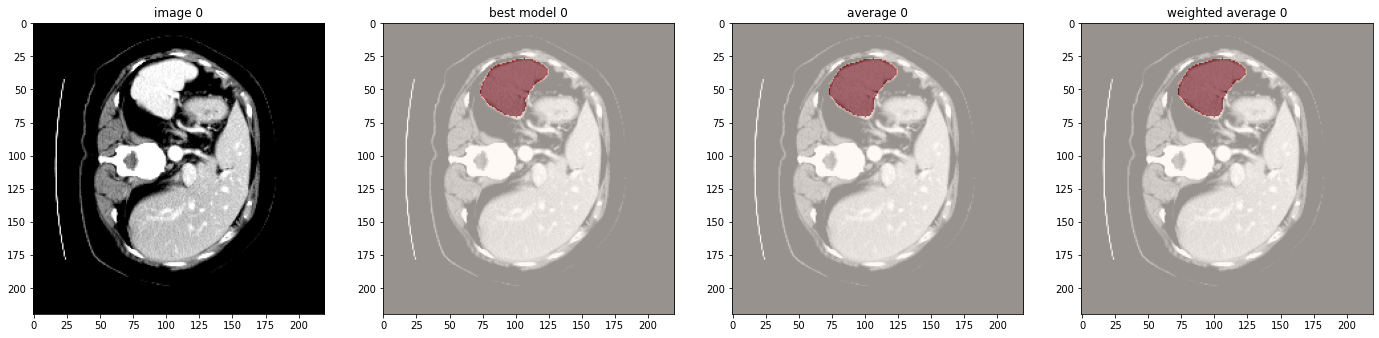

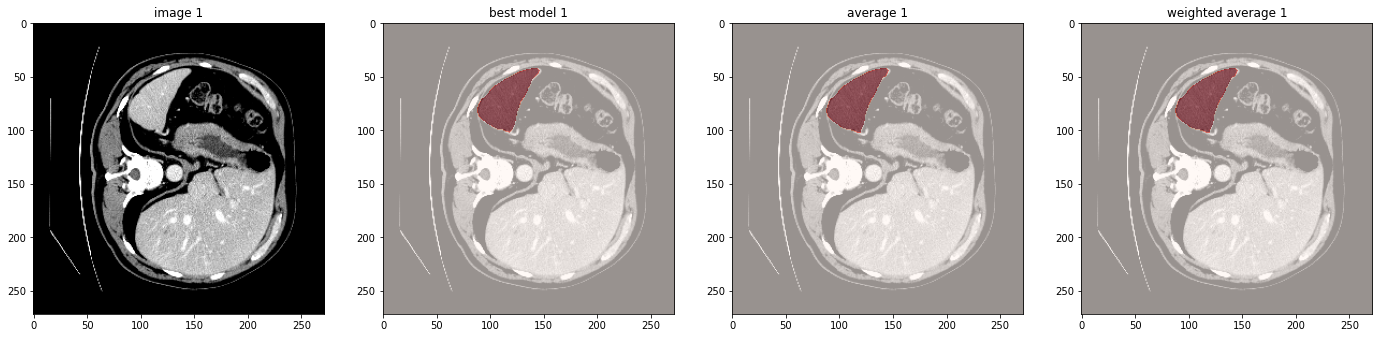

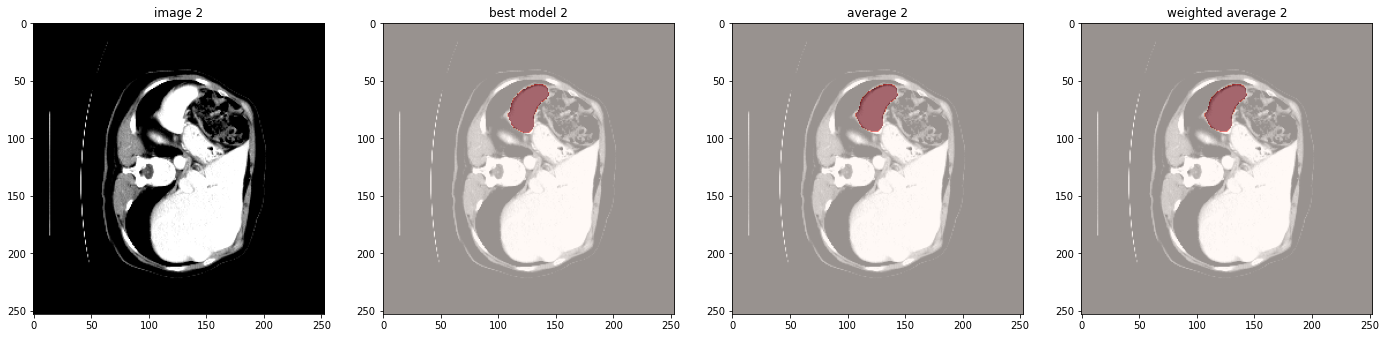

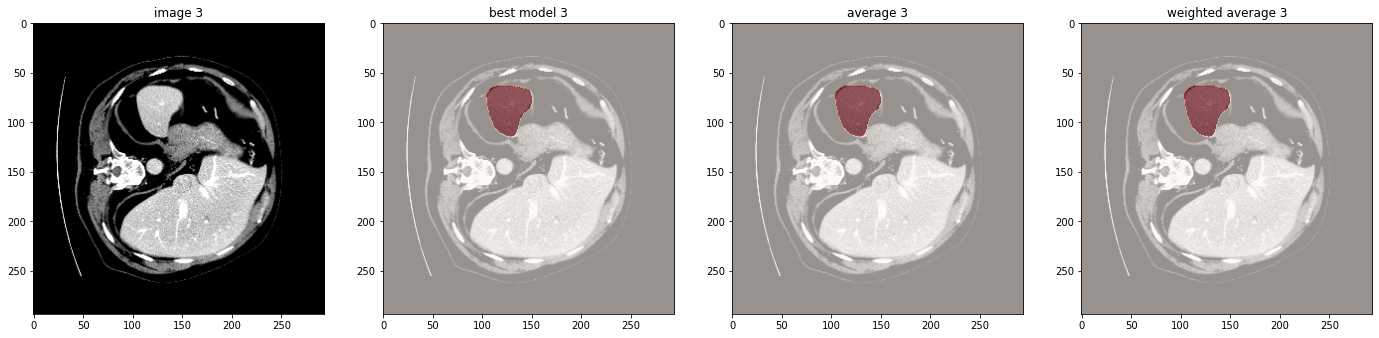

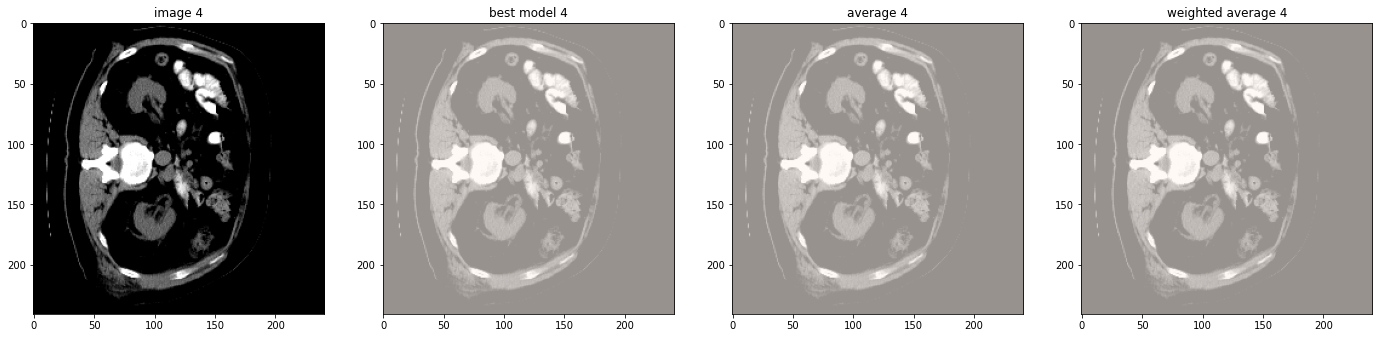

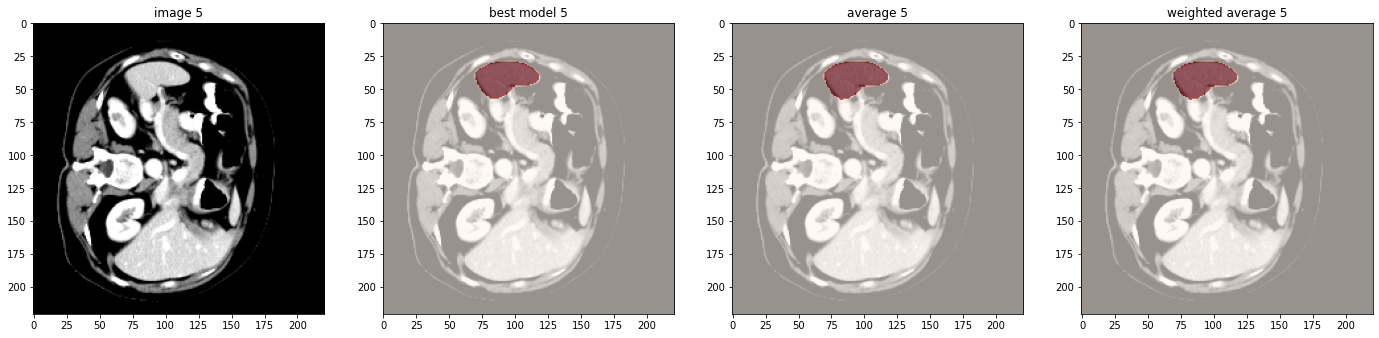

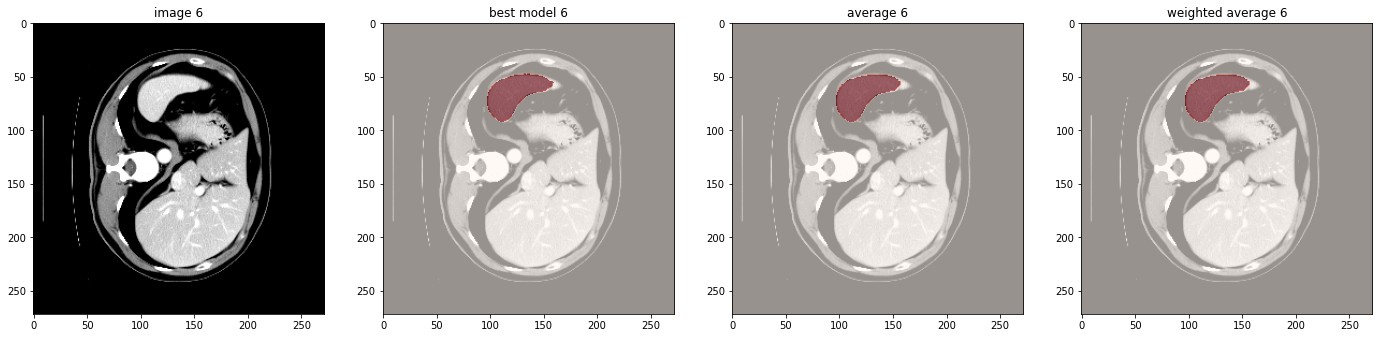

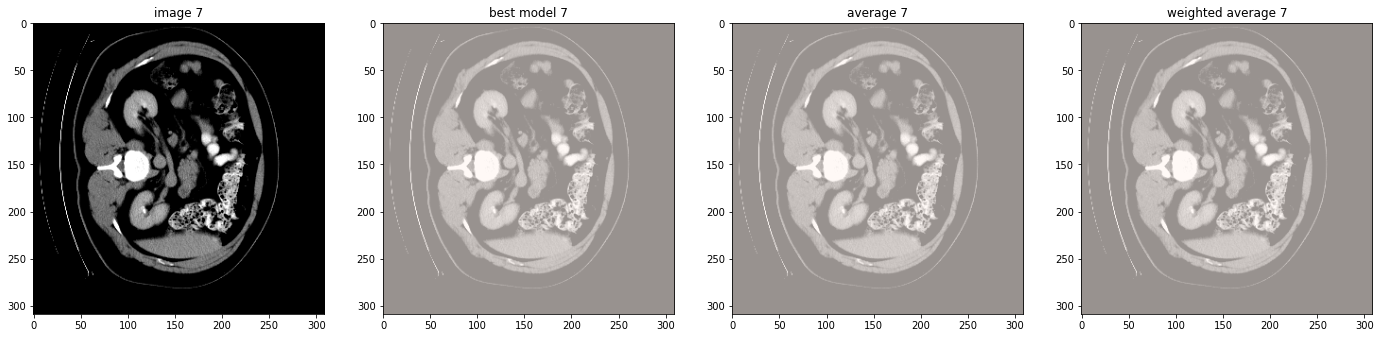

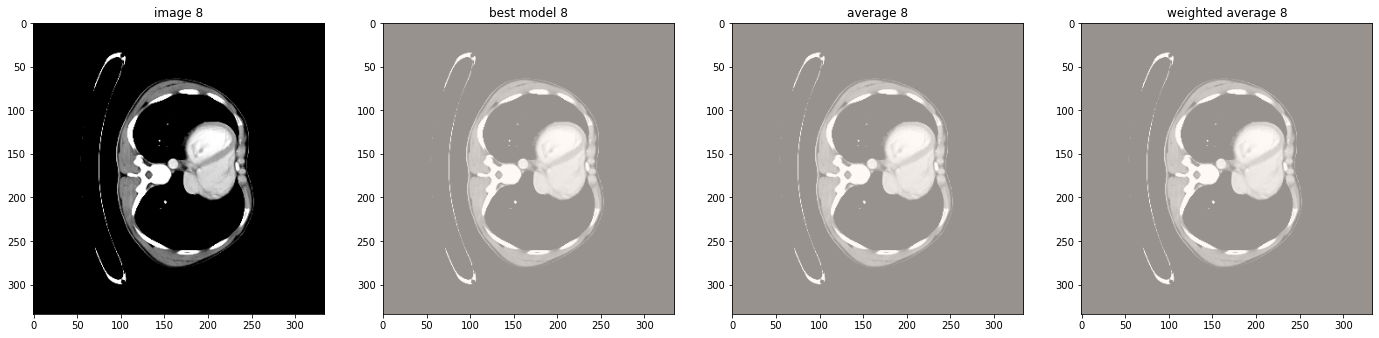

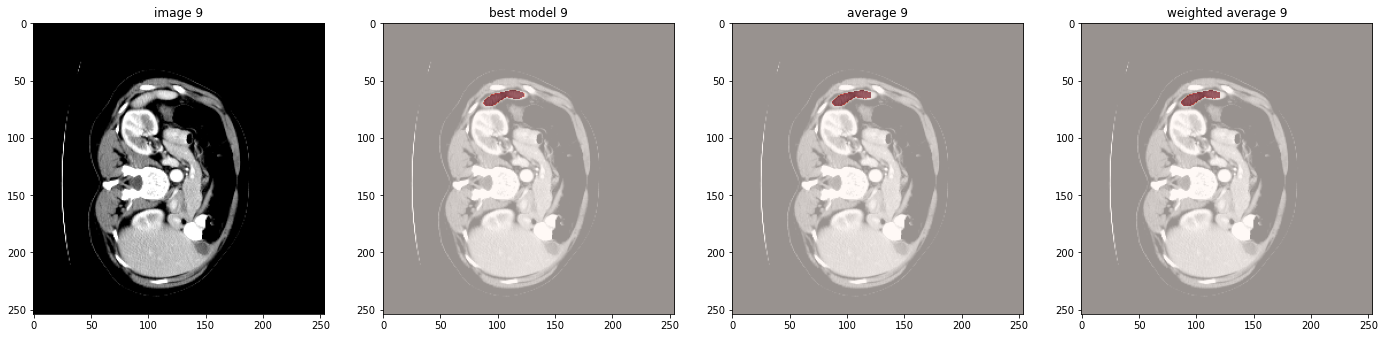

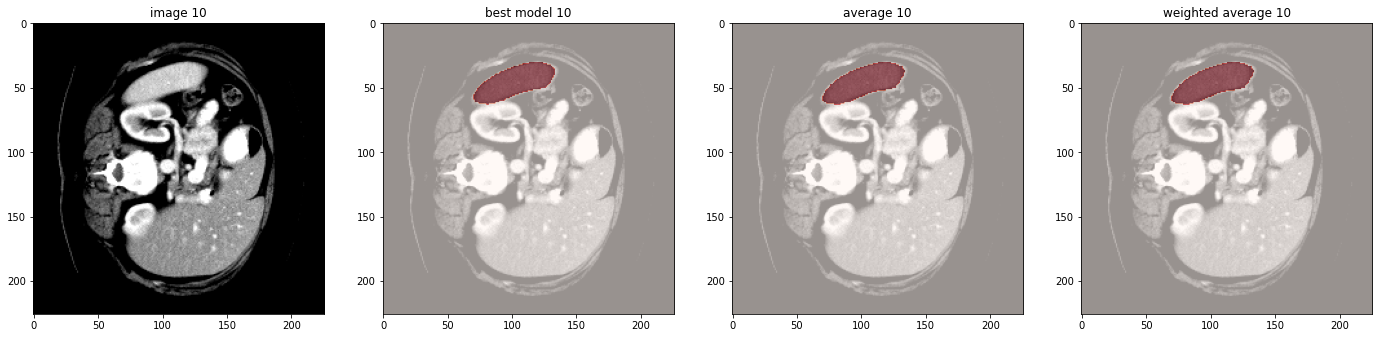

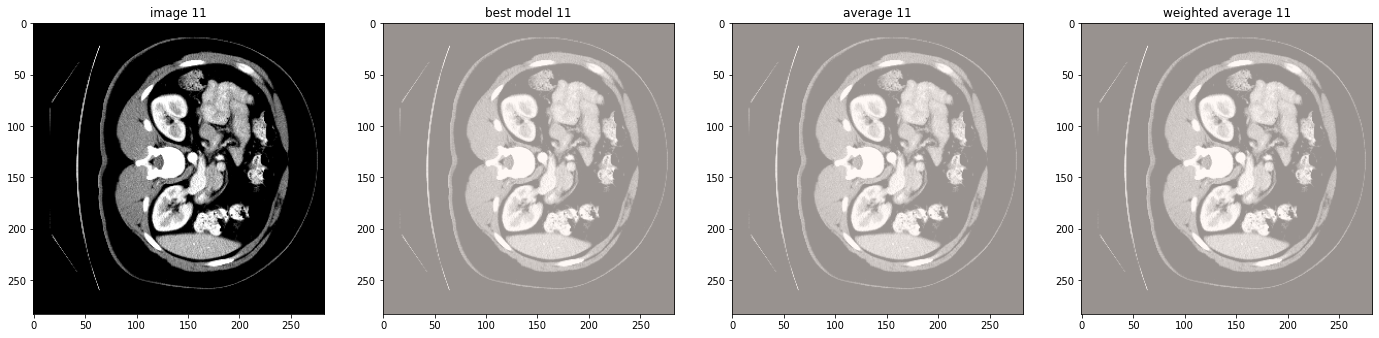

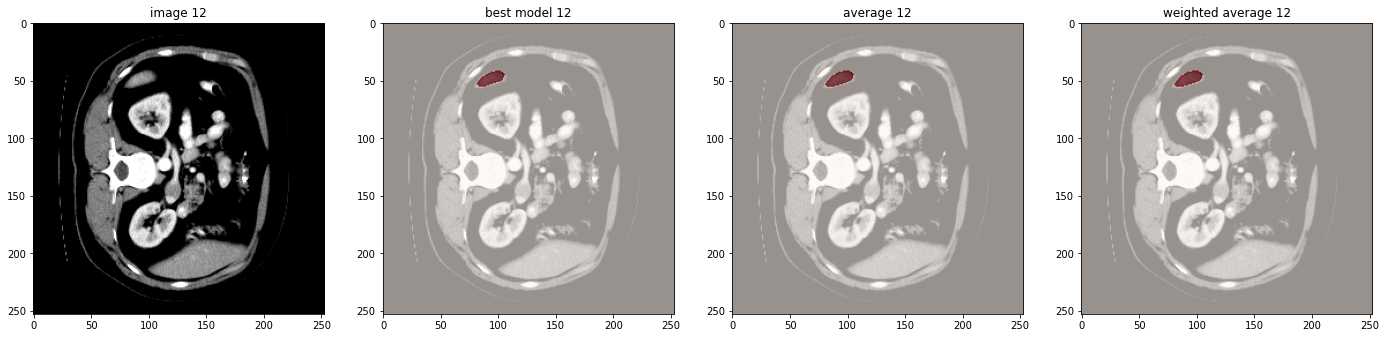

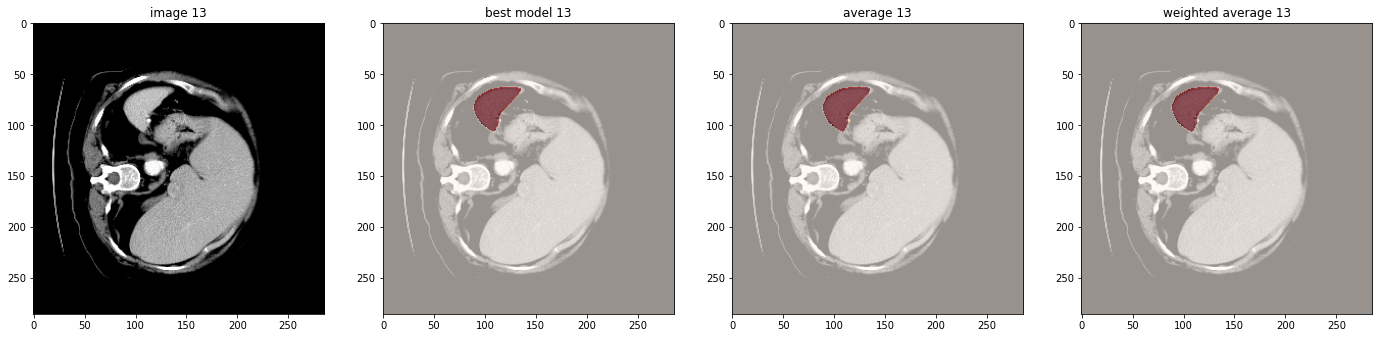

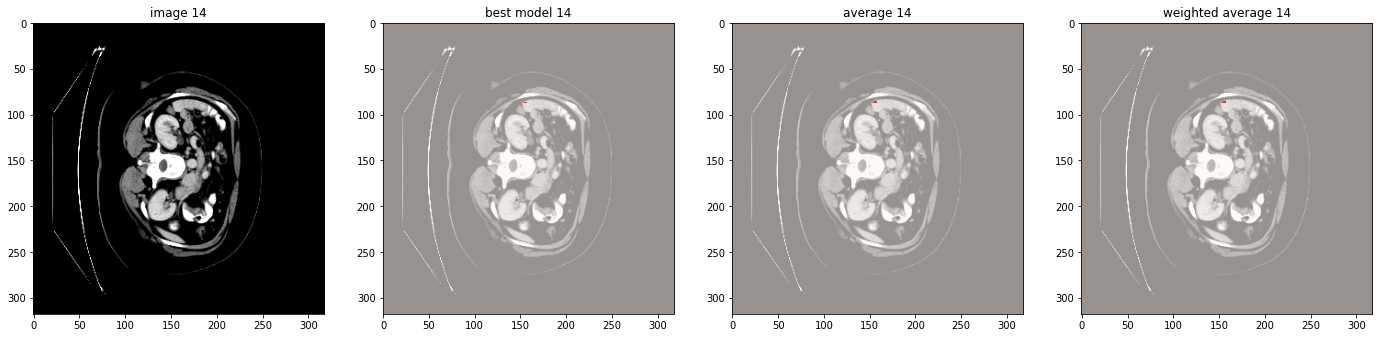

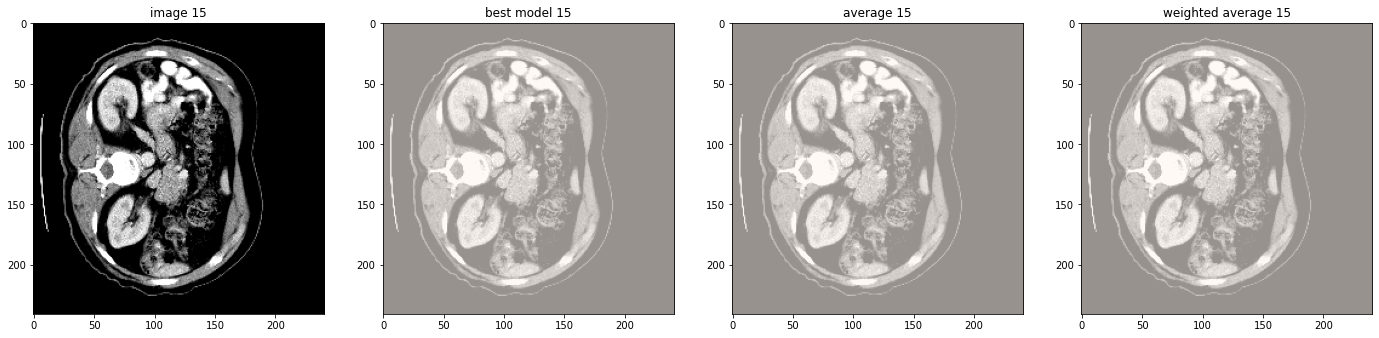

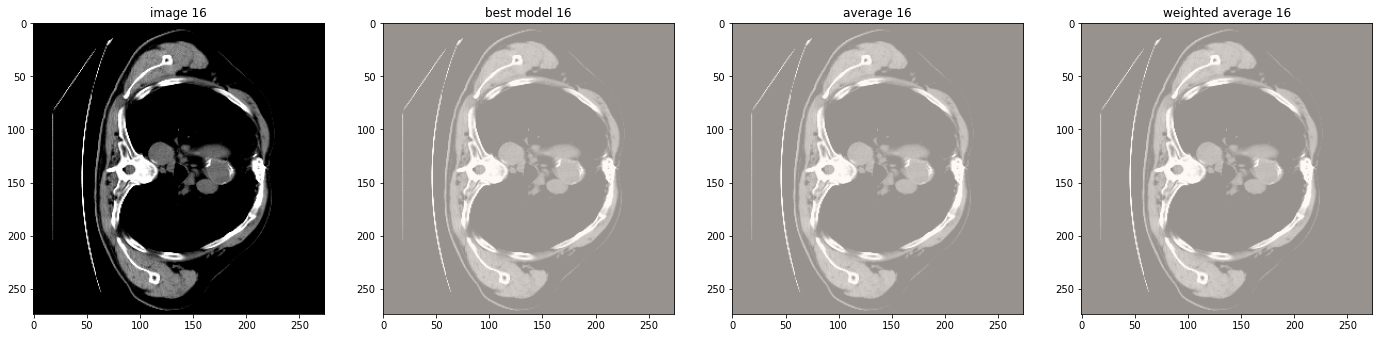

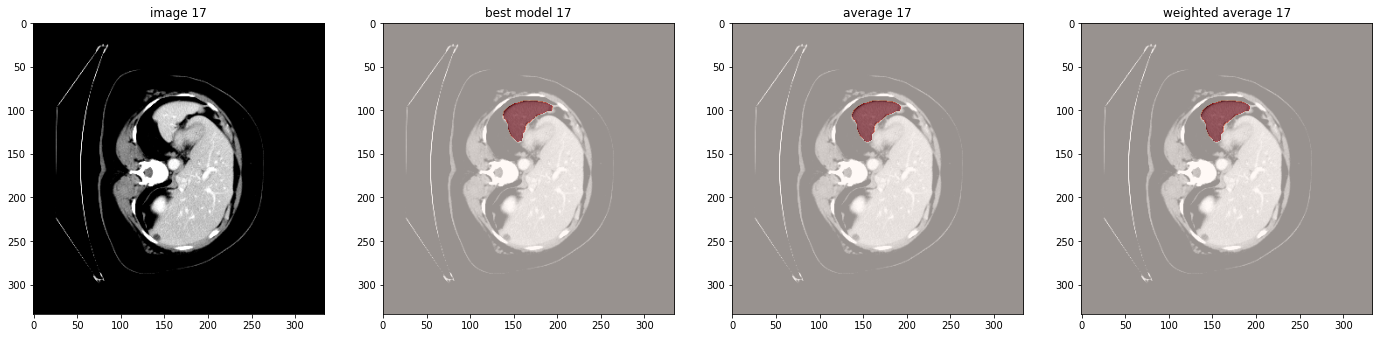

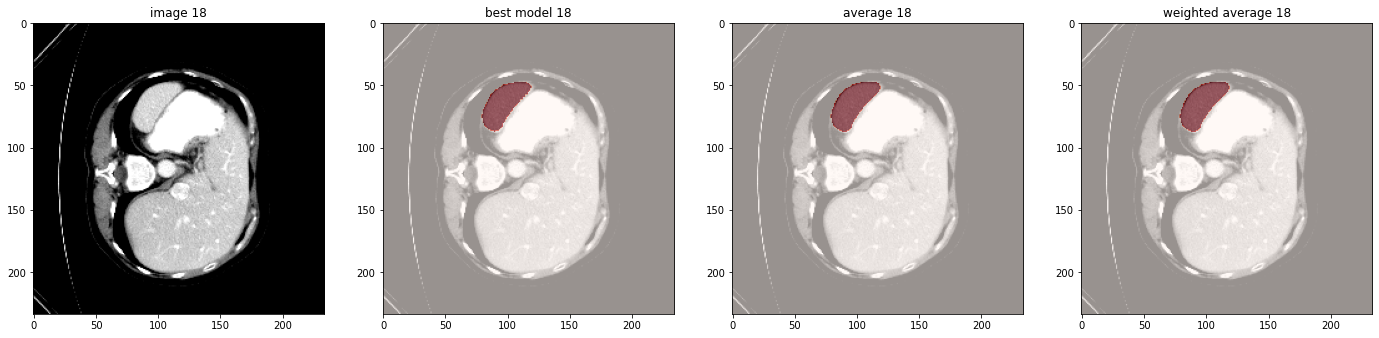

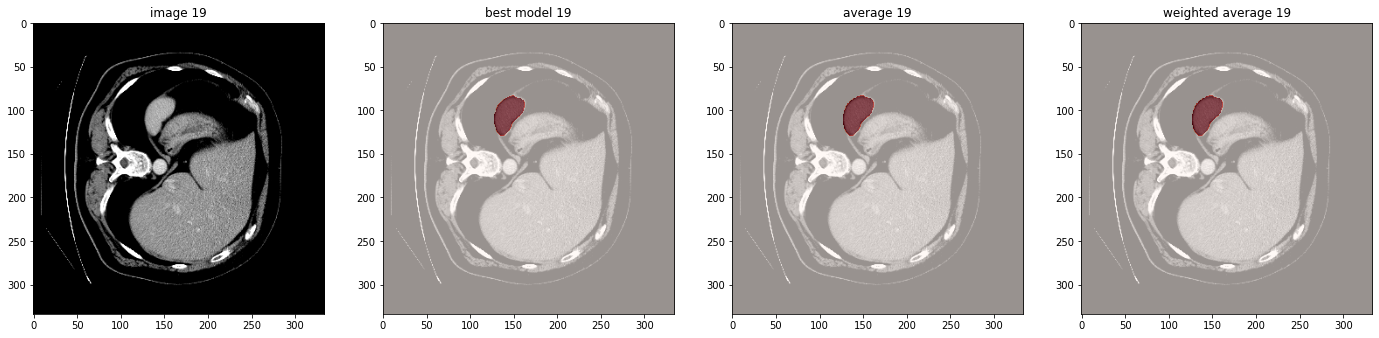

In [26]:
with torch.no_grad():

    for i,test_data in enumerate(test_loader):
        test_input = test_data["image"].to(device)

        z = test_input.size()[4]
        z = int(2*z/3)

        plt.figure("check", (24, 6))

        plt.subplot(1, 4, 1)
        plt.title(f"image {i}")
        plt.imshow(test_input[0, 0, :, :, z].cpu(), cmap="gray")

        plt.subplot(1, 4, 2)
        plt.title(f"best model {i}")
        plt.imshow(test_input[0, 0, :, :, z].cpu(), cmap="gray")
        plt.imshow(torch.argmax(
                predictions4[i], dim=1).detach().cpu()[0,:, :, z],alpha=0.6,cmap="Reds")
        
        plt.subplot(1, 4, 3)
        plt.title(f"average {i}")
        plt.imshow(test_input[0, 0, :, :, z].cpu(), cmap="gray")
        plt.imshow(torch.argmax(
                avg_prediction[i], dim=1).detach().cpu()[0,:, :, z],alpha=0.6,cmap="Reds")
        
        plt.subplot(1, 4, 4)
        plt.title(f"weighted average {i}")
        plt.imshow(test_input[0, 0, :, :, z].cpu(), cmap="gray")
        plt.imshow(torch.argmax(
                weighted_avg_preiction[i], dim=1).detach().cpu()[0,:, :, z],alpha=0.6,cmap="Reds")
        
        
        plt.show()

## Resize and Save 

*   resizing predictions to their initial dimensions
*   Saving them as nifti image




In [34]:
from scipy.ndimage import zoom
import nibabel as nib

In [35]:
root_dir = 'test_predictions'
data_dir1 = os.path.join(root_dir,"best_model","labelsTs")
data_dir2 = os.path.join(root_dir,"avg_model","labelsTs")
data_dir3 = os.path.join(root_dir,"weighted_avg_model","labelsTs")
print(data_dir)

MONAI_DATA_DIRECTORY/3D_Spleen


In [36]:
def resize(predictions,path):
    for i in range(20):
      string = data_dicts[i]["image"][0]
      name = string[40:]
      print(name,"\n")
      image = nib.load(string)
      x,y,z = image.header.get_data_shape()
      numpy_output = torch.argmax(
                predictions[i], dim=1).detach().cpu().numpy()
      numpy_output = numpy_output[0]
      x0,y0,z0 = numpy_output.shape
      zoom_ratio = (x/x0 , y/y0 , z/z0)
      result = zoom(numpy_output, zoom_ratio,order=1)
      nifti_image = nib.Nifti1Image(result, affine=np.eye(4))
      nib.save(nifti_image, os.path.join(path, name))

In [ ]:
resize(predictions4,data_dir1)
resize(avg_prediction,data_dir2)
resize(weighted_avg_preiction,data_dir3)